Pixel size: 0.582019 micron/pixel
Found 9946 candidate ROIs within the mask.
         x     y  r_half_pixels  r_half_microns  first_negative_amp  \
0     1170   230       9.365461        5.450876           -0.026308   
1     1180   230       9.449653        5.499877           -0.028448   
2     1190   230       9.433024        5.490199           -0.031830   
3     1200   230       9.450978        5.500648           -0.032480   
4     1210   230       9.413620        5.478906           -0.026893   
...    ...   ...            ...             ...                 ...   
9941  1030  1530      11.651757        6.781544           -0.114431   
9942  1040  1530      11.604043        6.753773           -0.111372   
9943  1050  1530      11.482718        6.683160           -0.099795   
9944  1060  1530      11.677556        6.796559           -0.098904   
9945  1070  1530      11.761070        6.845166           -0.096946   

      second_positive_distance_pixels  second_positive_distance_micron

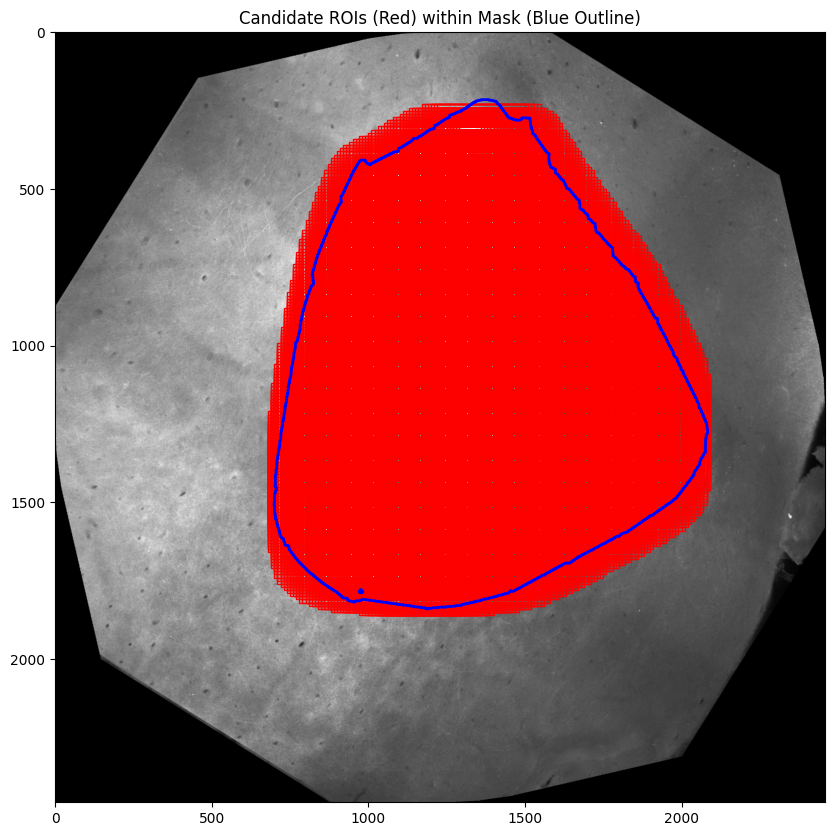

metritcs_df was saved as metrics_df/LGN_99.csv
CPU times: user 17.9 s, sys: 6.74 s, total: 24.6 s
Wall time: 3min 8s


In [17]:
%%time
## parallel processingでradial profileとmetrics(orientation含む)を各tileにつき求める
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from skimage import img_as_float, measure
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter, map_coordinates
from numpy.fft import fft2, ifft2, fftshift
import pandas as pd
from pathlib import Path


# CPU parallel processing:
import multiprocessing as mp

# GPU imports for background subtraction acceleration
import cupy as cp
import cupyx.scipy.ndimage as cndimage

#########################################
# Functions for Autocorrelation Analysis
#########################################

def next_power_of_two(n):
    return 2**int(np.ceil(np.log2(n)))

def bandpass_filter(image, sigma_small=3, sigma_large=40):
    g_small = gaussian_filter(image, sigma=sigma_small)
    g_large = gaussian_filter(image, sigma=sigma_large)
    return g_small - g_large

def pad_image_with_mean(image, pad_size):
    h, w = image.shape
    padded = np.full((pad_size, pad_size), np.mean(image), dtype=image.dtype)
    offset_y = (pad_size - h) // 2
    offset_x = (pad_size - w) // 2
    padded[offset_y:offset_y+h, offset_x:offset_x+w] = image
    return padded, offset_x, offset_y

def compute_autocorrelation(image):
    F = fft2(image)
    auto_corr = ifft2(np.abs(F)**2).real
    return fftshift(auto_corr)

def radial_profile(data, center, max_radius):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    radial_mean = []
    radii = np.arange(0, max_radius+1)
    for r_val in radii:
        mask = (r >= r_val) & (r < r_val+1)
        if np.any(mask):
            radial_mean.append(data[mask].mean())
        else:
            radial_mean.append(np.nan)
    return radii, np.array(radial_mean)

def background_subtract_gpu(image, selem_radius=50):
    image_gpu = cp.asarray(image)
    y, x = cp.ogrid[-selem_radius:selem_radius+1, -selem_radius:selem_radius+1]
    selem = (x**2 + y**2) <= selem_radius**2
    selem = selem.astype(cp.bool_)
    result_gpu = cndimage.white_tophat(image_gpu, footprint=selem)
    return cp.asnumpy(result_gpu)

def autocorrelation_radial_profile(image, do_bandpass=True, sigma_small=3, sigma_large=40,
                                   pad_factor=1.3, radial_limit_factor=0.3, debug=False,
                                   subtract_background=False, rolling_radius=50):
    if subtract_background:
        image = background_subtract_gpu(image, selem_radius=rolling_radius)
    if do_bandpass:
        image_filtered = bandpass_filter(image, sigma_small, sigma_large)
    else:
        image_filtered = image.copy()
    
    image_mean = np.mean(image_filtered)
    h, w = image_filtered.shape
    n_pixels = h * w

    target_size = int(np.ceil(pad_factor * max(w, h)))
    new_size = next_power_of_two(target_size)
    if debug:
        print("Padded size:", new_size)
    padded_image, _, _ = pad_image_with_mean(image_filtered, new_size)
    if debug:
        plt.figure(); plt.imshow(padded_image, cmap='gray'); plt.title("Padded Image"); plt.colorbar(); plt.show()
    
    auto_corr = compute_autocorrelation(padded_image)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis'); plt.title("Autocorrelation (Raw)"); plt.colorbar(); plt.show()
    
    auto_corr -= n_pixels * (image_mean**2)
    if debug:
        plt.figure(); plt.imshow(auto_corr, cmap='viridis'); plt.title("After Mean Subtraction"); plt.colorbar(); plt.show()
    
    mask = np.ones((h, w), dtype=float)
    padded_mask, _, _ = pad_image_with_mean(mask, new_size)
    ref_corr = compute_autocorrelation(padded_mask)
    ref_corr[ref_corr == 0] = 1.0
    auto_corr_corrected = auto_corr / ref_corr
    if debug:
        plt.figure(); plt.imshow(auto_corr_corrected, cmap='viridis'); plt.title("Corrected Autocorrelation"); plt.colorbar(); plt.show()
    
    center = new_size // 2
    norm_value = auto_corr_corrected[center, center]
    if debug:
        print("Normalization value (center):", norm_value)
    if norm_value != 0:
        auto_corr_corrected /= norm_value
    else:
        print("Warning: norm_value is zero; skipping normalization.")
    
    max_radius = new_size // 2
    radii, profile = radial_profile(auto_corr_corrected, (center, center), max_radius)
    if debug:
        plt.figure(); plt.plot(radii, profile, marker='o'); 
        plt.title("Radial Profile"); plt.xlabel("Radius (pixels)"); plt.ylabel("Normalized Autocorrelation");
        plt.grid(True); plt.show()
    
    return radii, profile, auto_corr_corrected

##############################################
# Global variables for multiprocessing workers
##############################################
global_rsc_img = None
global_pixel_size = None
roi_size = 330
pattern = r'[-_](\d+)\.tif$'

def process_tile(tile_coords):
    x, y = tile_coords
    roi = global_rsc_img[y:y+roi_size, x:x+roi_size]
    # Get autocorrelation radial profile and the corrected autocorrelation map
    radii, profile, auto_corr_map = autocorrelation_radial_profile(roi, do_bandpass=True, sigma_small=3, sigma_large=40,
                                                                   pad_factor=1.3, radial_limit_factor=0.3,
                                                                   debug=False, subtract_background=True, rolling_radius=50)
    # Metric 1: 50% width of the first peak
    r_half = None
    for i in range(1, len(profile)):
        if profile[i] <= 0.5:
            r_half = radii[i-1] + (0.5 - profile[i-1])*(radii[i]-radii[i-1])/(profile[i]-profile[i-1])
            break
    
    # Metric 2: Amplitude of the first negative peak (value below 0)
    first_negative_amp = None
    for i in range(1, len(profile)-1):
        if profile[i] < 0 and profile[i] < profile[i-1] and profile[i] < profile[i+1]:
            first_negative_amp = profile[i]
            break
    
    # Metric 3: Distance to the second positive peak (first local max above 0 after center)
    second_positive_distance = None
    for i in range(1, len(profile)-1):
        if profile[i] > 0 and profile[i] > profile[i-1] and profile[i] > profile[i+1]:
            second_positive_distance = radii[i]
            break

    # Metric 4: Orientation of maximum on the circle.
    # Compute the center of the autocorrelation map:
    new_size_map = auto_corr_map.shape[0]  # assume square
    center_pt = np.array([new_size_map//2, new_size_map//2])
    Y, X = np.indices(auto_corr_map.shape)
    r_map = np.sqrt((X - center_pt[1])**2 + (Y - center_pt[0])**2)
    exclusion_mask = r_map > 5  # exclude center
    # Find the most negative value (smallest) in auto_corr_map outside the center:
    neg_vals = auto_corr_map[exclusion_mask]
    min_val = np.min(neg_vals)
    min_coords = np.argwhere((auto_corr_map == min_val) & exclusion_mask)
    if min_coords.shape[0] > 0:
        min_coord = min_coords[0]
    else:
        min_coord = center_pt
    vec = np.array([min_coord[1] - center_pt[1], min_coord[0] - center_pt[0]])
    R_val = np.linalg.norm(vec)
    # Sample points on the circle of radius R_val from the center
    num_samples = 360
    angles = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
    circle_vals = []
    for angle in angles:
        x_sample = center_pt[1] + R_val * np.cos(angle)
        y_sample = center_pt[0] + R_val * np.sin(angle)
        val = map_coordinates(auto_corr_map, [[y_sample], [x_sample]], order=1, mode='reflect')[0]
        circle_vals.append(val)
    circle_vals = np.array(circle_vals)
    max_val_on_circle = np.max(circle_vals)
    max_index = np.argmax(circle_vals)
    orientation_max = angles[max_index]  # in radians

    return {
        'x': x,
        'y': y,
        'r_half_pixels': r_half,
        'r_half_microns': r_half * global_pixel_size if r_half is not None else None,
        'first_negative_amp': first_negative_amp,
        'second_positive_distance_pixels': second_positive_distance,
        'second_positive_distance_microns': second_positive_distance * global_pixel_size if second_positive_distance is not None else None,
        'orientation_max_radians': orientation_max,
        'orientation_max_degrees': np.degrees(orientation_max)
    }

#######################################
# Main code: Tiling and Metrics Extraction
#######################################
if __name__ == "__main__":
    # File paths
    rsc_path = 'LGN_99.tif'
    mask_path = 'Mask_99.tif'
    
    # path to save metrics_df
    metrics_dir = Path("./metrics_df") # Define the base directory
    csv_filename = rsc_path.replace('.tif', '.csv')
    csv_path = metrics_dir / csv_filename
    
    # Read main image and mask; convert to float.
    rsc_img = tifffile.imread(rsc_path)
    mask_img = tifffile.imread(mask_path)
    rsc_img = img_as_float(rsc_img)
    mask_img = img_as_float(mask_img)
    
    # Extract pixel size from main image metadata (using XResolution)
    with tifffile.TiffFile(rsc_path) as tif:
        page = tif.pages[0]
        x_res_fraction = page.tags['XResolution'].value
        pixel_size = x_res_fraction[0] / x_res_fraction[1]
        print("Pixel size:", pixel_size, "micron/pixel")
    
    # Set globals for worker processes.
    global_rsc_img = rsc_img
    global_pixel_size = pixel_size
    
    # Create a binary mask from mask image.
    mask_binary = mask_img > 0.5
    
    # Tiling parameters
    stride = 10  # slide window by 10 pixels
    coverage_threshold = 0.9  # require at least 90% mask coverage in ROI
    
    # Collect candidate tile positions
    tile_positions = []
    for y in range(0, rsc_img.shape[0] - roi_size + 1, stride):
        for x in range(0, rsc_img.shape[1] - roi_size + 1, stride):
            roi_mask = mask_binary[y:y+roi_size, x:x+roi_size]
            if roi_mask.mean() >= coverage_threshold:
                tile_positions.append((x, y))
    
    print(f"Found {len(tile_positions)} candidate ROIs within the mask.")
    
    # Use multiprocessing.Pool to process candidate ROIs in parallel.
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(process_tile, tile_positions)
    
    metrics_df = pd.DataFrame(results)
    print(metrics_df)
    
    # Visualization: draw candidate ROI rectangles and overlay mask outline.
    import matplotlib.patches as patches
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(rsc_img, cmap='gray')
    for (x, y) in tile_positions:
        rect = patches.Rectangle((x, y), roi_size, roi_size, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(rect)
    contours = find_contours(mask_binary, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
    ax.set_title("Candidate ROIs (Red) within Mask (Blue Outline)")
    plt.show()
    
    # Save or further process metrics_df as needed.
    metrics_df.to_csv(csv_path)
    print(f'metritcs_df was saved as {csv_path}')



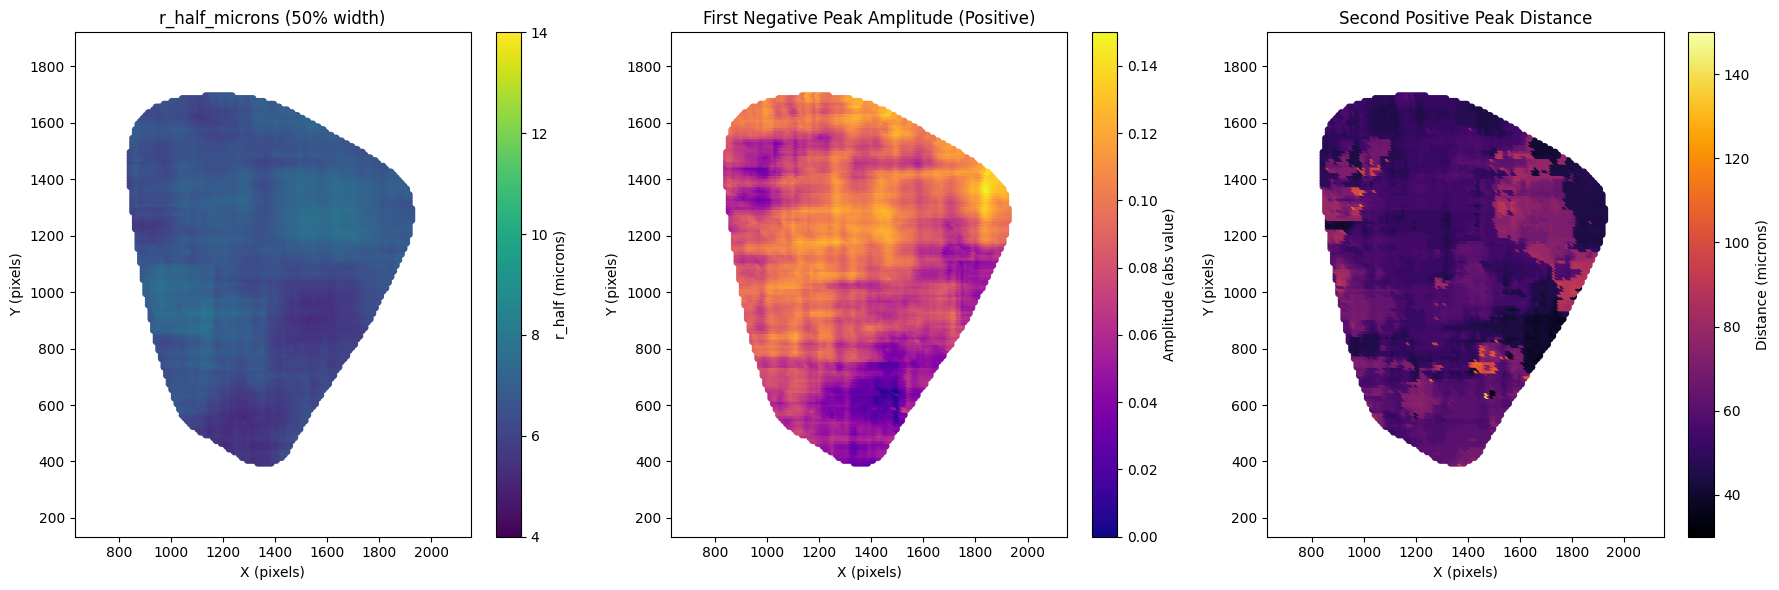

In [18]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours

# Compute ROI center coordinates (assuming roi_size is defined)
roi_center_x = metrics_df['x'] + roi_size/2
roi_center_y = metrics_df['y'] + roi_size/2

# Convert first_negative_amp to positive by multiplying by -1
first_negative_amp_positive = -metrics_df['first_negative_amp']

# Extract mask contours from the binary mask
contours = find_contours(mask_binary, level=0.5)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Set fixed ranges for the color maps (adjust these as needed)
vmin_rhalf, vmax_rhalf = 4, 14                       # for r_half_microns
vmin_neg, vmax_neg = 0, 0.15                          # for the positive-converted negative amplitude
vmin_second, vmax_second = 30, 150                     # for second_positive_distance_microns

# Plot 1: r_half_microns (50% width)
sc1 = axs[0].scatter(roi_center_x, roi_center_y, 
                     c=metrics_df['r_half_microns'], cmap='viridis', s=20,
                     vmin=vmin_rhalf, vmax=vmax_rhalf)
for contour in contours:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[0].set_title("r_half_microns (50% width)")
axs[0].set_xlabel("X (pixels)")
axs[0].set_ylabel("Y (pixels)")
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("r_half (microns)")

# Plot 2: first_negative_amp converted to positive
sc2 = axs[1].scatter(roi_center_x, roi_center_y, 
                     c=first_negative_amp_positive, cmap='plasma', s=20,
                     vmin=vmin_neg, vmax=vmax_neg)
for contour in contours:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[1].set_title("First Negative Peak Amplitude (Positive)")
axs[1].set_xlabel("X (pixels)")
axs[1].set_ylabel("Y (pixels)")
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Amplitude (abs value)")

# Plot 3: second_positive_distance_microns (distance to second positive peak)
sc3 = axs[2].scatter(roi_center_x, roi_center_y, 
                     c=metrics_df['second_positive_distance_microns'], cmap='inferno', s=20,
                     vmin=vmin_second, vmax=vmax_second)
for contour in contours:
    axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[2].set_title("Second Positive Peak Distance")
axs[2].set_xlabel("X (pixels)")
axs[2].set_ylabel("Y (pixels)")
cbar3 = fig.colorbar(sc3, ax=axs[2])
cbar3.set_label("Distance (microns)")

plt.tight_layout()
plt.show()


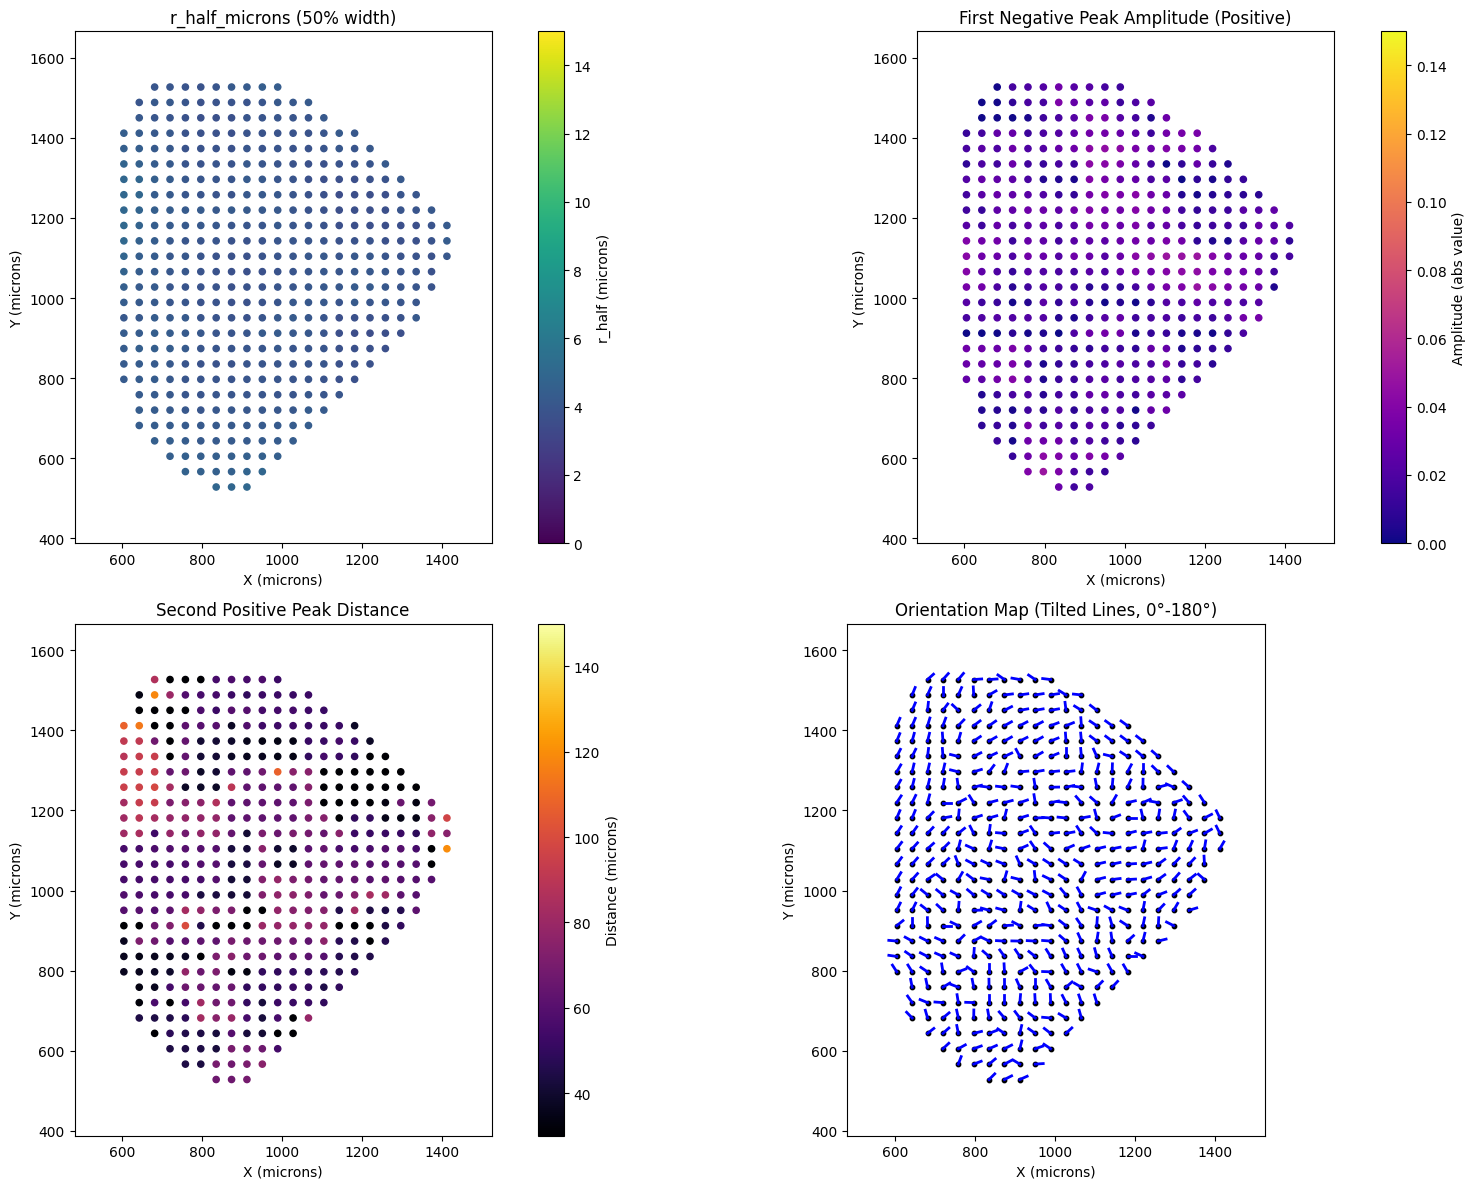

In [3]:
## radial profileから求めたmetricsをmap (orientationあり)
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import numpy as np

# Adjust orientation values to range [0, 180)
metrics_df['orientation_max_degrees'] = metrics_df['orientation_max_degrees'] % 180
metrics_df['orientation_max_radians'] = np.deg2rad(metrics_df['orientation_max_degrees'])

# Compute ROI center coordinates (assuming roi_size is defined)
roi_center_x = (metrics_df['x'] + roi_size/2) * pixel_size
roi_center_y = (metrics_df['y'] + roi_size/2) * pixel_size

# Convert mask contours from pixels to microns.
contours_microns = []
for contour in find_contours(mask_binary, level=0.5):
    contour_m = contour * pixel_size
    contours_microns.append(contour_m)

# Create a 2x2 subplot layout.
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.ravel()  # flatten to 1D array for easier indexing

# Set fixed ranges for the color maps (adjust these as needed)
vmin_rhalf, vmax_rhalf = 0, 15           # for r_half_microns
vmin_neg, vmax_neg = 0, 0.15             # for positive-converted first_negative_amp
vmin_second, vmax_second = 30, 150       # for second_positive_distance_microns

# Panel 1: r_half_microns (50% width)
sc1 = axs[0].scatter(roi_center_x, roi_center_y, 
                     c=metrics_df['r_half_microns'], cmap='viridis', s=20,
                     vmin=vmin_rhalf, vmax=vmax_rhalf)
for contour in contours_microns:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[0].set_title("r_half_microns (50% width)")
axs[0].set_xlabel("X (microns)")
axs[0].set_ylabel("Y (microns)")
axs[0].set_aspect('equal', adjustable='box')
cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label("r_half (microns)")

# Panel 2: first_negative_amp (converted to positive)
first_negative_amp_positive = -metrics_df['first_negative_amp']
sc2 = axs[1].scatter(roi_center_x, roi_center_y, 
                     c=first_negative_amp_positive, cmap='plasma', s=20,
                     vmin=vmin_neg, vmax=vmax_neg)
for contour in contours_microns:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[1].set_title("First Negative Peak Amplitude (Positive)")
axs[1].set_xlabel("X (microns)")
axs[1].set_ylabel("Y (microns)")
axs[1].set_aspect('equal', adjustable='box')
cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label("Amplitude (abs value)")

# Panel 3: second_positive_distance_microns
sc3 = axs[2].scatter(roi_center_x, roi_center_y, 
                     c=metrics_df['second_positive_distance_microns'], cmap='inferno', s=20,
                     vmin=vmin_second, vmax=vmax_second)
for contour in contours_microns:
    axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[2].set_title("Second Positive Peak Distance")
axs[2].set_xlabel("X (microns)")
axs[2].set_ylabel("Y (microns)")
axs[2].set_aspect('equal', adjustable='box')
cbar3 = fig.colorbar(sc3, ax=axs[2])
cbar3.set_label("Distance (microns)")

# Panel 4: Orientation map as tilted lines.
# We'll draw a line (of fixed length) from each ROI center in the direction given by orientation_max_degrees.
line_length = 20  # in microns; adjust as needed.
angles_rad = metrics_df['orientation_max_radians']  # already adjusted to [0, π)
x_end = roi_center_x + line_length * np.cos(angles_rad)
y_end = roi_center_y + line_length * np.sin(angles_rad)
for xc, yc, xe, ye in zip(roi_center_x, roi_center_y, x_end, y_end):
    axs[3].plot([xc, xe], [yc, ye], color='blue', linewidth=2)
# Plot ROI centers as small black dots.
axs[3].scatter(roi_center_x, roi_center_y, color='black', s=10)
for contour in contours_microns:
    axs[3].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
axs[3].set_title("Orientation Map (Tilted Lines, 0°-180°)")
axs[3].set_xlabel("X (microns)")
axs[3].set_ylabel("Y (microns)")
axs[3].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


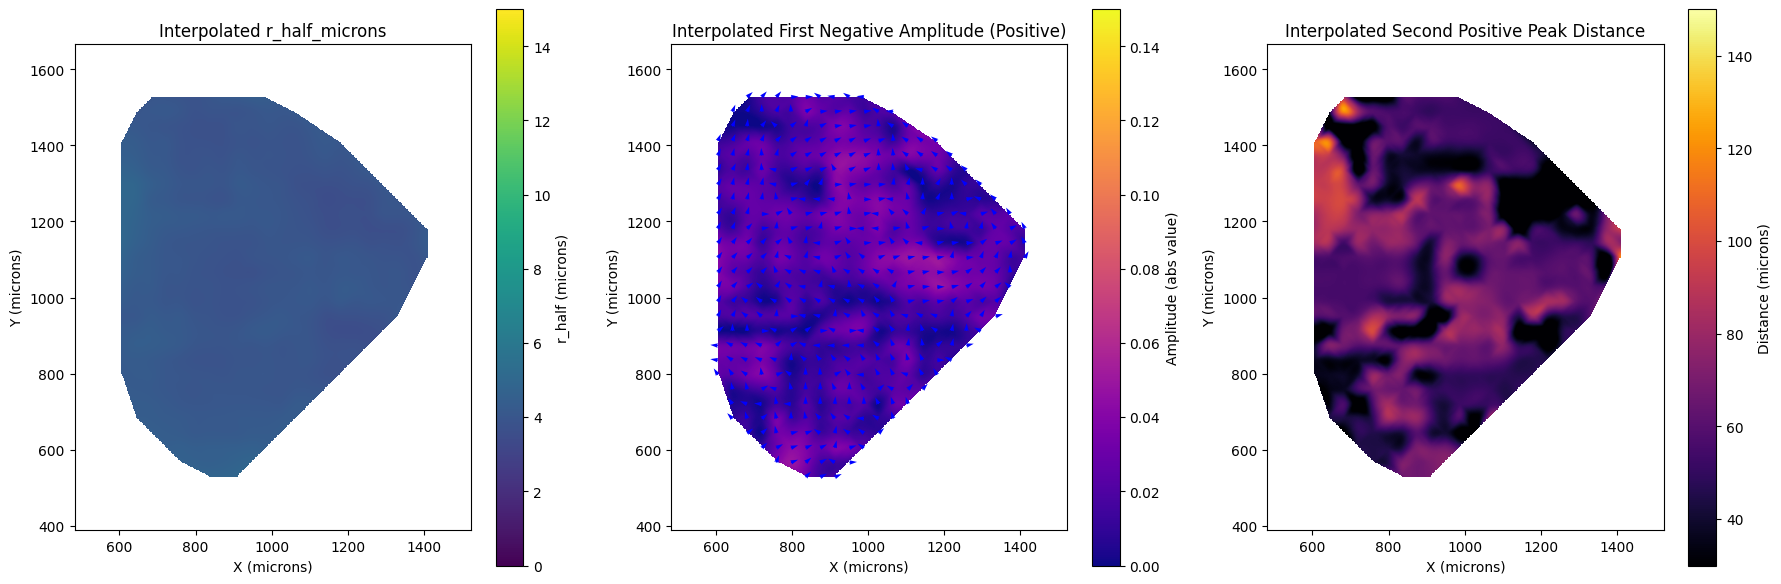

In [4]:
## radial profileから求めたmetricsをmap (orientationをoverlay)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from skimage.measure import find_contours

# Assume metrics_df is your DataFrame containing:
#   'x', 'y', 'r_half_microns', 'first_negative_amp', 'second_positive_distance_microns',
#   and 'orientation_max_degrees' (already in the 0–180 range).
# Also assume roi_size (e.g., 330) and pixel_size (microns per pixel) are defined.

# Compute ROI center coordinates (converted to microns)
roi_center_x = (metrics_df['x'] + roi_size/2) * pixel_size
roi_center_y = (metrics_df['y'] + roi_size/2) * pixel_size

# Convert first_negative_amp to positive
first_negative_amp_positive = -metrics_df['first_negative_amp']

# Extract mask contours (convert contour coordinates to microns)
contours = find_contours(mask_binary, level=0.5)
contours_microns = [contour * pixel_size for contour in contours]

# Define grid for interpolation based on ROI centers (in microns)
xi = np.linspace(roi_center_x.min(), roi_center_x.max(), 500)
yi = np.linspace(roi_center_y.min(), roi_center_y.max(), 500)
XI, YI = np.meshgrid(xi, yi)

# Interpolate Metric 1: r_half_microns
Z1 = griddata((roi_center_x, roi_center_y), metrics_df['r_half_microns'], (XI, YI), method='cubic')
Z1_m = np.ma.masked_invalid(Z1)

# Interpolate Metric 2: first_negative_amp_positive
Z2 = griddata((roi_center_x, roi_center_y), first_negative_amp_positive, (XI, YI), method='cubic')
Z2_m = np.ma.masked_invalid(Z2)

# Interpolate Metric 3: second_positive_distance_microns
Z3 = griddata((roi_center_x, roi_center_y), metrics_df['second_positive_distance_microns'], (XI, YI), method='cubic')
Z3_m = np.ma.masked_invalid(Z3)

# Create a figure with 3 subplots (Panel 2 will have the orientation overlay)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Fixed ranges for each colormap (adjust as needed)
vmin_rhalf, vmax_rhalf = 0, 15                       # for r_half_microns
vmin_neg, vmax_neg = 0, 0.15                         # for first_negative_amp_positive
vmin_second, vmax_second = 30, 150                   # for second_positive_distance_microns

# Panel 1: Interpolated r_half_microns
im1 = axs[0].imshow(Z1_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='viridis', vmin=vmin_rhalf, vmax=vmax_rhalf)
axs[0].set_title('Interpolated r_half_microns')
axs[0].set_xlabel('X (microns)')
axs[0].set_ylabel('Y (microns)')
axs[0].set_aspect('equal', adjustable='box')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label("r_half (microns)")
for contour in contours_microns:
    axs[0].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')

# Panel 2: Interpolated first_negative_amp_positive with orientation overlay
im2 = axs[1].imshow(Z2_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='plasma', vmin=vmin_neg, vmax=vmax_neg)
axs[1].set_title('Interpolated First Negative Amplitude (Positive)')
axs[1].set_xlabel('X (microns)')
axs[1].set_ylabel('Y (microns)')
axs[1].set_aspect('equal', adjustable='box')
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Amplitude (abs value)")
for contour in contours_microns:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')
    
# Overlay orientation arrows as tilted lines on Panel 2:
# Convert orientation_max_degrees (already in [0, 180]) to radians.
angles_rad = np.deg2rad(metrics_df['orientation_max_degrees'])
# Define fixed arrow length (in microns)
arrow_length = 20  
# Compute arrow endpoints
u = arrow_length * np.cos(angles_rad)
v = arrow_length * np.sin(angles_rad)
# Overlay arrows using quiver (color blue)
axs[1].quiver(roi_center_x, roi_center_y, u, v, color='blue', scale_units='xy', scale=1, width=0.005)

# Panel 3: Interpolated second_positive_distance_microns
im3 = axs[2].imshow(Z3_m, extent=(roi_center_x.min(), roi_center_x.max(), roi_center_y.min(), roi_center_y.max()),
                    origin='lower', cmap='inferno', vmin=vmin_second, vmax=vmax_second)
axs[2].set_title('Interpolated Second Positive Peak Distance')
axs[2].set_xlabel('X (microns)')
axs[2].set_ylabel('Y (microns)')
axs[2].set_aspect('equal', adjustable='box')
cbar3 = fig.colorbar(im3, ax=axs[2])
cbar3.set_label("Distance (microns)")
for contour in contours_microns:
    axs[2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')

plt.tight_layout()
plt.show()
